In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the iedfinance api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [3]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# api = tradeapi.REST()
api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [6]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ["SPY","AGG"]

# Set timeframe to '1D'
timeframe = '1D'

# Set start and end datetimes of 1 year.
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for AAPL
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df
df.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)

In [7]:
df.head()

,AGG,SPY
,close,close
time,,
2019-01-02 00:00:00-05:00,106.585,249.89
2019-01-03 00:00:00-05:00,107.020,244.46
2019-01-04 00:00:00-05:00,106.695,252.41
2019-01-07 00:00:00-05:00,106.470,254.40
2019-01-08 00:00:00-05:00,106.420,256.65


In [8]:
df.shape

(252, 2)

# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 100 iterations and generate at least 30 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 30 years

In [9]:
# Calculate the daily roi for the stocks
daily_returns = df.pct_change()
daily_returns.head()

,AGG,SPY
,close,close
time,,
2019-01-02 00:00:00-05:00,NaN,NaN
2019-01-03 00:00:00-05:00,0.004081,-0.021730
2019-01-04 00:00:00-05:00,-0.003037,0.032521
2019-01-07 00:00:00-05:00,-0.002109,0.007884
2019-01-08 00:00:00-05:00,-0.000470,0.008844


In [10]:
# volatility
daily_volatility = daily_returns.std()
spy_volatility = daily_volatility['SPY']['close']
agg_volatility = daily_volatility['AGG']['close']

In [11]:
# Save the last day's closing price
spy_last_price = df['SPY']['close'][-1]
agg_last_price = df['AGG']['close'][-1]

In [12]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()

In [13]:
# Run the Monte Carlo Simulation
for x in range(number_simulations):
    
    print(f"Running Simulation {x}...")
    
    # Create the initial simulated prices array seeded with the last closing price
    spy_prices = [spy_last_price]
    agg_prices = [agg_last_price]
    
    # Simulate the returns for 20 years
    for _ in range(number_records):
        spy_prices.append(
            spy_prices[-1] * (1 + np.random.normal(daily_returns.mean()['SPY']['close'], spy_volatility)))
        agg_prices.append(
            agg_prices[-1] * (1 + np.random.normal(daily_returns.mean()['AGG']['close'], agg_volatility)))

    # Create a DataFrame of the simulated prices
    portfolio = pd.DataFrame({
        "SPY Simulated Prices": spy_prices,
        "AGG Simulated Prices": agg_prices
    })

    # Calculate the Portfolio Daily Returns
    portfolio_returns=portfolio.pct_change()
    
    # Set the Portfolio Weights (Assume a 60/40 stocks to bonds ratio)
    stocks_weight = 0.60
    bonds_weight = 0.40
    
    
    # Calculate the weighted portfolio return: 
    portfolio_returns = stocks_weight * portfolio_returns['SPY Simulated Prices'] + bonds_weight * portfolio_returns['AGG Simulated Prices']
    
    # Calculate the normalized, cumulative return series
    monte_carlo[x] = (1 + portfolio_returns.fillna(0)).cumprod()

Running Simulation 0...
Running Simulation 1...
Running Simulation 2...
Running Simulation 3...
Running Simulation 4...
Running Simulation 5...
Running Simulation 6...
Running Simulation 7...
Running Simulation 8...
Running Simulation 9...
Running Simulation 10...
Running Simulation 11...
Running Simulation 12...
Running Simulation 13...
Running Simulation 14...
Running Simulation 15...
Running Simulation 16...
Running Simulation 17...
Running Simulation 18...
Running Simulation 19...
Running Simulation 20...
Running Simulation 21...
Running Simulation 22...
Running Simulation 23...
Running Simulation 24...
Running Simulation 25...
Running Simulation 26...
Running Simulation 27...
Running Simulation 28...
Running Simulation 29...
Running Simulation 30...
Running Simulation 31...
Running Simulation 32...
Running Simulation 33...
Running Simulation 34...
Running Simulation 35...
Running Simulation 36...
Running Simulation 37...
Running Simulation 38...
Running Simulation 39...
Running Si

In [14]:
# Check that the simulation ran successfully
monte_carlo.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.002924,0.995999,0.993589,0.999839,1.005673,1.006943,1.009401,0.996558,1.001958,0.999350,...,1.002269,0.995970,1.007308,1.000163,0.997898,1.003207,0.996441,0.994146,1.003209,0.997553
2,1.007960,0.999998,0.993068,0.999039,1.009071,0.998193,1.004123,0.986299,1.001346,1.007829,...,1.004518,1.003370,1.010545,1.001969,0.999475,1.000274,0.996136,0.994776,1.003311,1.001444
3,1.007370,1.000231,0.996724,0.993520,1.008617,1.001408,1.008137,0.980584,1.001321,1.016101,...,1.004743,1.006240,1.015344,1.003629,0.993173,0.999241,1.000000,1.000495,1.006827,1.000482
4,1.016195,1.003283,0.993397,0.999441,1.010295,0.996675,1.007118,0.978044,1.009298,1.006308,...,1.006802,1.004677,1.014131,1.008910,0.999443,0.996475,0.994644,1.001387,1.011503,1.004131


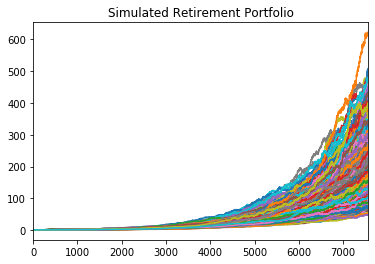

In [15]:
# Visualize the Simulation
monte_carlo.plot(legend=None, title="Simulated Retirement Portfolio")

In [16]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
ending_returns = monte_carlo.iloc[-1, :]

In [17]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
ending_returns = monte_carlo.tail(1).T
ending_returns.head()

,7560
0,224.965889
1,185.695782
2,254.090683
3,267.175574
4,242.897877


In [18]:
# Display the 90% confidence interval for the ending returns
confidence_interval = ending_returns.quantile(q=[0.05, 0.95], numeric_only=True)
confidence_interval

,7560
0.05,94.350911
0.95,374.693262


<Figure size 432x288 with 0 Axes>

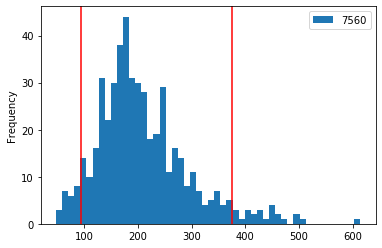

In [19]:
# Visualize the distribution of the ending returns
plt.figure();
ending_returns.plot.hist(bins=50)
plt.axvline(confidence_interval.iloc[0, 0], color='r')
plt.axvline(confidence_interval.iloc[1, 0], color='r')

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [20]:
ending_returns.quantile([.01, .5, .9])

,7560
0.01,65.488469
0.50,189.843833
0.90,314.347361


### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [21]:
initial_investment = 20000 
initial_investment * ending_returns.quantile([.01, .5, .9])

,7560
0.01,1.309769e+06
0.50,3.796877e+06
0.90,6.286947e+06


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [22]:
plaid_projected_annual_income =  7389

# Calculate the 4% withdrawal for the ending return as retirement income
retirement_income = .04 * (initial_investment * ending_returns.quantile(.1)).iloc[0]

# Determine if the retirement income meets or exceeds the current projected income
if retirement_income >= plaid_projected_annual_income:
    print(f"You will have ${retirement_income:.2f} in retirement income which is sufficient")
else:
    print(f"You will have ${retirement_income:.2f} in retirement income which is not sufficient")

You will have $93900.76 in retirement income which is sufficient


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [23]:
# Re-calculate the retirement income with a 50% increase in the initial investment amount
.04 * (1.5 * initial_investment * ending_returns.quantile(.1)).iloc[0]

140851.13488258983

### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [24]:
projected_returns = monte_carlo.quantile(q=[0.05, .5, .95], axis=1, numeric_only=True).T
projected_returns.head()

,0.05,0.50,0.95
0,1.000000,1.000000,1.000000
1,0.992971,1.000809,1.008777
2,0.991139,1.001774,1.012423
3,0.989299,1.002378,1.016104
4,0.987312,1.003325,1.017700


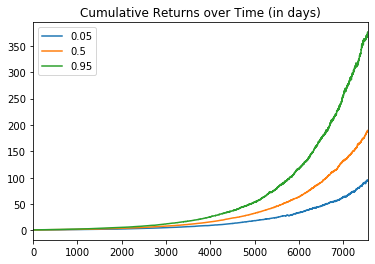

In [25]:
projected_returns.plot(title="Cumulative Returns over Time (in days)")

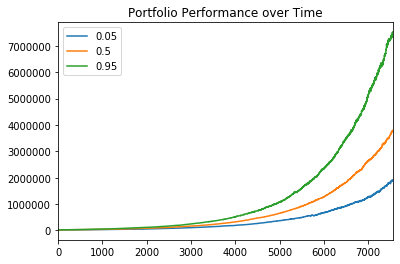

In [26]:
(initial_investment * projected_returns).plot(title="Portfolio Performance over Time")